<a href="https://colab.research.google.com/github/parseny/Generative-Models-2024/blob/main/Assignment%202/DCGAN_LS_SN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torchvision
from torchvision import transforms
from torchvision.transforms import ToTensor, Normalize, Compose
from torchvision.datasets import MNIST, CIFAR10
from IPython.display import Image
from torchvision.utils import save_image
import os
%matplotlib inline
plt.style.use("ggplot")

class CFG:
    batch_size = 128
    num_epochs = 300
    workers = 4
    seed = 2021
    image_size = 64
    download = True
    dataroot = "/home/jupyter/datasphere/project/Generative-Models-2024/Assignment 2/data"
    nc = 3  ## number of chanels
    ngf = 64  # Size of feature maps in generator
    nz = 100  # latent random input vector
    ndf = 64  # Size of feature maps in discriminator
    lr = 0.0002
    device = "cuda" if torch.cuda.is_available() else "cpu"
    sample_dir = "./images/"


if not os.path.exists(CFG.sample_dir):
    os.makedirs(CFG.sample_dir)

In [ ]:
cifar_dataset = CIFAR10(
    root=CFG.dataroot,
    download=CFG.download,
    transform=transforms.Compose(
        [
            transforms.Resize([CFG.image_size, CFG.image_size]),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ]
    ),
)

Files already downloaded and verified


Label:  4


(array([  13.,   48.,  406., 1048.,  874., 1419., 1658., 1769., 1851.,
        1198.,  947.,  589.,  267.,  153.,   48.]),
 array([-0.81176472, -0.75843138, -0.70509803, -0.65176469, -0.59843141,
        -0.54509807, -0.49176472, -0.43843138, -0.38509804, -0.3317647 ,
        -0.27843139, -0.22509804, -0.1717647 , -0.11843137, -0.06509804,
        -0.01176471]),
 <BarContainer object of 15 artists>)

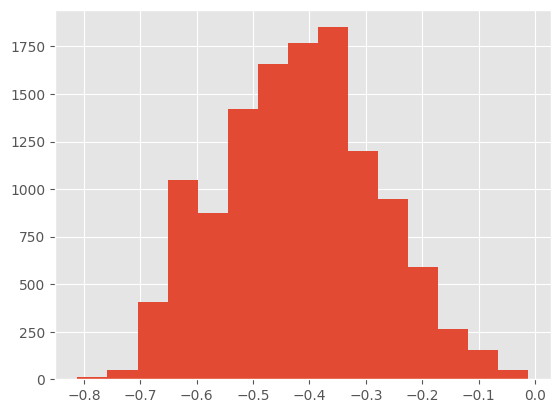

In [ ]:
img, label = cifar_dataset[25]
print("Label: ", label)
plt.hist(img[:, :, :].flatten(), bins=15)

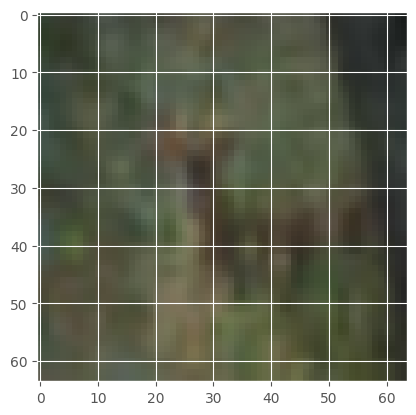

In [ ]:
# unnormalization image from range (-1)-1 to range 0-1 to display it
def denorm(img):
    return (img + 1) / 2

# show  image sample with matplotlib
imgplot = plt.imshow(denorm(img.permute(1, 2, 0)))

**Tricks**
- use deeper CNN
- use LeakyRELU instead of ReLU
- use BatchNorm, Dropout
- SpectralNorm

# LS + SN

## Technic setup

In [21]:
import torch
from torch.optim.optimizer import Optimizer, required

from torch.autograd import Variable
import torch.nn.functional as F
from torch import nn
from torch import Tensor
from torch.nn import Parameter

def l2normalize(v, eps=1e-12):
    return v / (v.norm() + eps)


class SpectralNorm(nn.Module):
    def __init__(self, module, name='weight', power_iterations=1):
        super(SpectralNorm, self).__init__()
        self.module = module
        self.name = name
        self.power_iterations = power_iterations
        if not self._made_params():
            self._make_params()

    def _update_u_v(self):
        u = getattr(self.module, self.name + "_u")
        v = getattr(self.module, self.name + "_v")
        w = getattr(self.module, self.name + "_bar")

        height = w.data.shape[0]
        for _ in range(self.power_iterations):
            v.data = l2normalize(torch.mv(torch.t(w.view(height,-1).data), u.data))
            u.data = l2normalize(torch.mv(w.view(height,-1).data, v.data))

        # sigma = torch.dot(u.data, torch.mv(w.view(height,-1).data, v.data))
        sigma = u.dot(w.view(height, -1).mv(v))
        setattr(self.module, self.name, w / sigma.expand_as(w))

    def _made_params(self):
        try:
            u = getattr(self.module, self.name + "_u")
            v = getattr(self.module, self.name + "_v")
            w = getattr(self.module, self.name + "_bar")
            return True
        except AttributeError:
            return False


    def _make_params(self):
        w = getattr(self.module, self.name)

        height = w.data.shape[0]
        width = w.view(height, -1).data.shape[1]

        u = Parameter(w.data.new(height).normal_(0, 1), requires_grad=False)
        v = Parameter(w.data.new(width).normal_(0, 1), requires_grad=False)
        u.data = l2normalize(u.data)
        v.data = l2normalize(v.data)
        w_bar = Parameter(w.data)

        del self.module._parameters[self.name]

        self.module.register_parameter(self.name + "_u", u)
        self.module.register_parameter(self.name + "_v", v)
        self.module.register_parameter(self.name + "_bar", w_bar)


    def forward(self, *args):
        self._update_u_v()
        return self.module.forward(*args)

In [26]:
import torch.nn as nn
# Generator
class Generator(nn.Module):
    def __init__(self, nc, nz, ngf):
        super(Generator, self).__init__()
        self.sequential = nn.Sequential(
            nn.ConvTranspose2d(nz, ngf * 16, kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(ngf * 16),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(ngf * 16, ngf * 8, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),

            # Second ConvTranspose2d: from ngf*8 to ngf*4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),

            # Third ConvTranspose2d: from ngf*4 to ngf*2
            nn.ConvTranspose2d(ngf * 4, ngf * 2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),

            # Fourth ConvTranspose2d: from ngf*2 to ngf
            nn.ConvTranspose2d(ngf * 2, ngf, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),

            # Final ConvTranspose2d: from ngf to nc (output channels)
            nn.ConvTranspose2d(ngf, nc, kernel_size=3, padding=1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        x = input.view(input.shape[0], input.shape[1], 1, 1)
        x = self.sequential(x)
        return x


def initialize_weights(model):
    classname = model.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(model.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(model.weight.data, 1.0, 0.02)
        nn.init.constant_(model.bias.data, 0) 

# Discriminator

class SNDiscriminator(nn.Module):
    def __init__(self, nc, ndf):
        super(SNDiscriminator, self).__init__()
        self.sequential = nn.Sequential(
            # Первый слой: от (nc, 64, 64) до (ndf, 32, 32), без BatchNorm и Dropout
            SpectralNorm(nn.Conv2d(nc, ndf, kernel_size=4, stride=2, padding=1, bias=False)),
            nn.LeakyReLU(0.2, inplace=True),

            # Второй слой: от (ndf, 32, 32) до (ndf*2, 16, 16) с BatchNorm и Dropout
            SpectralNorm(nn.Conv2d(ndf, ndf * 2, kernel_size=4, stride=2, padding=1, bias=False)),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.5),

            # Третий слой: от (ndf*2, 16, 16) до (ndf*4, 8, 8) с BatchNorm и Dropout
            SpectralNorm(nn.Conv2d(ndf * 2, ndf * 4, kernel_size=4, stride=2, padding=1, bias=False)),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.5),

            # Четвертый слой: от (ndf*4, 8, 8) до (ndf*8, 4, 4) с BatchNorm и Dropout
            SpectralNorm(nn.Conv2d(ndf * 4, ndf * 8, kernel_size=4, stride=2, padding=1, bias=False)),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.5),

            # Пятый слой: от (ndf*8, 4, 4) до (1, 1, 1) с Sigmoid для классификации
            SpectralNorm(nn.Conv2d(ndf * 8, 1, kernel_size=4, stride=1, padding=0, bias=False)),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.sequential(x)
        return x.view(x.size(0), -1)

In [33]:
# create new Generator model
G = Generator(CFG.nc, CFG.nz, CFG.ngf)

# create new Discriminator model
D = SNDiscriminator(CFG.nc, CFG.ndf)

initialize_weights(G)
initialize_weights(D)

# define the criterion is nn.BCELoss()
criterion = nn.BCELoss()
## Define the optimizer for generator and discrimator
optimizer_G = torch.optim.Adam(G.parameters(), lr=CFG.lr*1.25, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(D.parameters(), lr=CFG.lr, betas=(0.5, 0.999))

In [ ]:
# show the output of model
y = G(torch.randn(2, CFG.nz))
print(y.shape)
single_image = denorm(y[0]).detach().numpy().transpose(1, 2, 0)

plt.imshow(single_image)

In [36]:
def reset_grad():
    optimizer_G.zero_grad()
    optimizer_D.zero_grad()
    ## reset gradient for optimizer of generator and discrimator

LABEL_SMOOTH = 0.8
def train_discriminator(images):

    # Create the labels which are later used as input for the BCE loss
    real_labels = torch.ones(batch_size, 1).to(device)*LABEL_SMOOTH
    fake_labels = torch.ones(batch_size, 1).to(device)*(1 - LABEL_SMOOTH)
    
    outputs = D_model(images)
    
    # Loss for real images
    real_score = outputs
    real_loss = criterion(real_score, real_labels)
    
    # Loss for fake images
    z = torch.randn(images.shape[0], CFG.nz).to(device)
    fake_images = G_model(z)
    outputs = D_model(fake_images)
    fake_score = outputs
    fake_loss = criterion(fake_score, fake_labels)
    
    # Sum losses
    d_loss = real_loss + fake_loss
    
    # Reset gradients
    reset_grad()
    
    # Compute gradients
    d_loss.backward()
    
    # Adjust the parameters using backprop
    optimizer_D.step()
    return d_loss, real_score, fake_score

def train_generator(G_model):
    # add noise
    z = np.random.normal(0, 1, (CFG.batch_size, CFG.nz))
    noise = 0.005*np.random.uniform()*np.amax(z)
    z = z.astype('float64') + noise*np.random.normal(size=z.shape)
    z = torch.Tensor(z).to(device)
    
    fake_images = G_model(z)
    fake_outputs = D(fake_images)
    labels = torch.ones(CFG.batch_size, 1).to(device)
    
    # calculate the generator loss
    g_loss = criterion(fake_outputs,labels)
    
    # Reset gradients
    reset_grad()
    
    # Backprop and optimize
    g_loss.backward()
    optimizer_G.step()
    return g_loss, fake_images

## Trainig Process

In [38]:
sample_dir = "/home/jupyter/datasphere/project/Generative-Models-2024/Assignment 2/LS+SN/images"
def save_fake_images(index):
    # sample_vectors = torch.randn(batch_size, latent_size).to(device)
    z = np.random.normal(0, 1, (CFG.batch_size, CFG.nz))
    noise = 0.005*np.random.uniform()*np.amax(z)
    z = z.astype('float64') + noise*np.random.normal(size=z.shape)
    z = torch.Tensor(z).to(device)
    fake_images = G(z)
    fake_images = fake_images.reshape(fake_images.size(0), 3, 64, 64)
    fake_fname = 'fake_images-{0:0=3d}.png'.format(index)
    print('Saving', fake_fname)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=10)

In [39]:
device = CFG.device
num_epochs = CFG.num_epochs
batch_size = CFG.batch_size

total_step = len(dataloader)
# G.load_state_dict(torch.load('/content/generator_v4.pth'))
# D.load_state_dict(torch.load('/content/discriminator_v4.pth'))
G.to(device)
D.to(device)

 d_losses, g_losses, real_scores, fake_scores, IS_scores, FID_scores = [], [], [], [], [], []

In [40]:
import torch

def load_checkpoint(checkpoint_path, G, D, optimizer_G, optimizer_D):
    checkpoint = torch.load(checkpoint_path)
    epoch = checkpoint['epoch']
    G.load_state_dict(checkpoint['generator_state_dict'])
    D.load_state_dict(checkpoint['discriminator_state_dict'])
    optimizer_G.load_state_dict(checkpoint['G_optimizer_state_dict'])
    optimizer_D.load_state_dict(checkpoint['D_optimizer_state_dict'])
    d_losses = checkpoint['d_losses']
    g_losses = checkpoint['g_losses']
    real_scores = checkpoint['real_scores']
    fake_scores = checkpoint['fake_scores']
    IS = checkpoint['IS']
    FID = checkpoint['FID']
    print(f"Checkpoint loaded from epoch {epoch+1}.")
    return epoch, d_losses, g_losses, real_scores, fake_scores, G, D, optimizer_G, optimizer_D, IS, FID

In [76]:
%%time
# start_epoch = 0

# If a checkpoint exists, load it and resume training
# try:
#     start_epoch, d_losses, g_losses, real_scores, fake_scores = load_checkpoint(path+"checkpoint.pth", G, D, optimizer_G, optimizer_D)
# except FileNotFoundError:
#     print("No checkpoint found, starting training from scratch.")

num_epochs = 40

for epoch in range(start_epoch, num_epochs+1):
    for i, (images, _) in enumerate(dataloader):
        if i == 390:
            break
        # Load a batch & transform to vectors
        images = images.to(device)
        G.train()
    
        # Train the discriminator
        D.train()
        d_loss, real_score, fake_score = train_discriminator(D, G, images)

        # Train the generator
        G.train()
        g_loss, fake_images = train_generator(G)

        # Inspect the losses
        if (i + 1) % 130 == 0:
            d_losses.append(d_loss.item())
            g_losses.append(g_loss.item())
            real_scores.append(real_score.mean().item())
            fake_scores.append(fake_score.mean().item())
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{total_step}], '
                  f'd_loss: {d_loss.item():.4f}, g_loss: {g_loss.item():.4f}, '
                  f'D(x): {real_score.mean().item():.2f}, D(G(z)): {fake_score.mean().item():.2f}')

    # Sample and save images
    save_fake_images(epoch+1)
    if epoch % 5 == 0:
        G.eval()
        dataset = GeneratorDataset(G, CFG.nz)
        G_dataloader = DataLoader(dataset, batch_size=32, shuffle=True)
        # Inception Score
        # IS, _ = get_inception_score(G_dataloader)
        # print(f"Inception Score: {IS}")
        # # Frechet Inception Distance
        # FID = get_fid(G_dataloader, 'cifar10.train.npz')
        # print(f"FID: {FID}")
        (IS, IS_std), FID = get_inception_score_and_fid(G_dataloader, '/home/jupyter/datasphere/project/Generative-Models-2024/Assignment 2/cifar10.train.npz')
        IS_scores.append(IS)
        FID_scores.append(FID)
        print(f"Epoch [{epoch}/{num_epochs}], Inception Score: {IS}, FID: {FID}")
        checkpoint = {
            'epoch': epoch,
            'generator_state_dict': G.state_dict(),
            'discriminator_state_dict': D.state_dict(),
            'G_optimizer_state_dict': optimizer_G.state_dict(),
            'D_optimizer_state_dict': optimizer_D.state_dict(),
            'd_losses': d_losses,
            'g_losses': g_losses,
            'real_scores': real_scores,
            'fake_scores': fake_scores,
            'IS': IS_scores,
            'FID': FID_scores
        }
        torch.save(checkpoint, f"/home/jupyter/datasphere/project/Generative-Models-2024/Assignment 2/LS+SN/checkpoints/checkpoint_{epoch+1}.pth")


Epoch [0/300], Step [185/391], d_loss: 1.3661, g_loss: 1.1136, D(x): 0.53, D(G(z)): 0.41
Epoch [0/300], Step [370/391], d_loss: 1.2596, g_loss: 1.3975, D(x): 0.65, D(G(z)): 0.41
Saving fake_images-001.png
Checkpoint saved at epoch 0.
Epoch [1/300], Step [185/391], d_loss: 1.3374, g_loss: 1.1096, D(x): 0.57, D(G(z)): 0.42
Epoch [1/300], Step [370/391], d_loss: 1.4678, g_loss: 0.8995, D(x): 0.44, D(G(z)): 0.42
Saving fake_images-002.png
Checkpoint saved at epoch 1.
Epoch [2/300], Step [185/391], d_loss: 1.3664, g_loss: 0.9314, D(x): 0.53, D(G(z)): 0.42
Epoch [2/300], Step [370/391], d_loss: 1.3297, g_loss: 0.9053, D(x): 0.56, D(G(z)): 0.44
Saving fake_images-003.png
Checkpoint saved at epoch 2.
Epoch [3/300], Step [185/391], d_loss: 1.2262, g_loss: 1.0250, D(x): 0.63, D(G(z)): 0.34
Epoch [3/300], Step [370/391], d_loss: 1.2651, g_loss: 1.0892, D(x): 0.61, D(G(z)): 0.39
Saving fake_images-004.png
Checkpoint saved at epoch 3.
Epoch [4/300], Step [185/391], d_loss: 1.3476, g_loss: 0.9555, D

## Eval

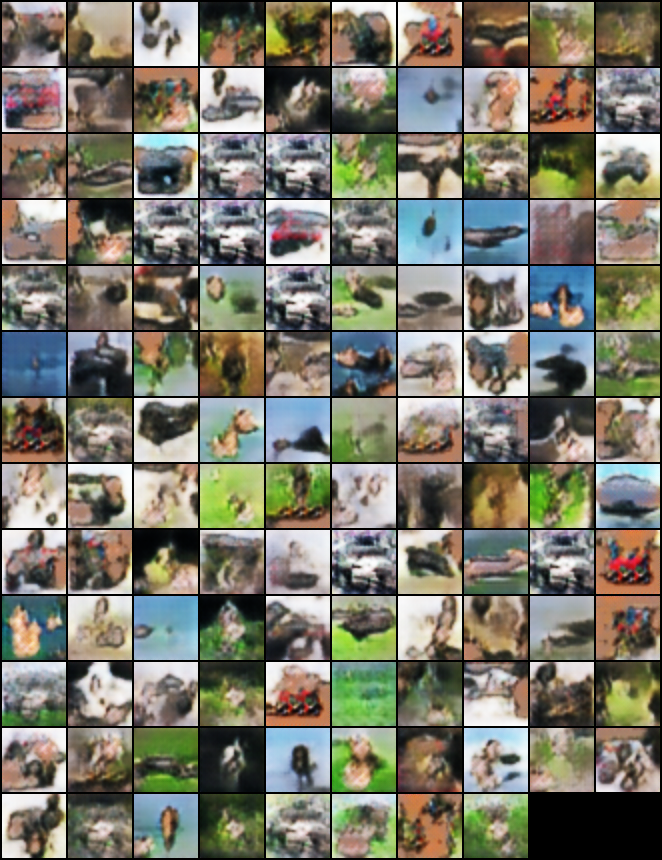

In [77]:
Image(os.path.join('images_LS+SN', 'fake_images-130.png'))

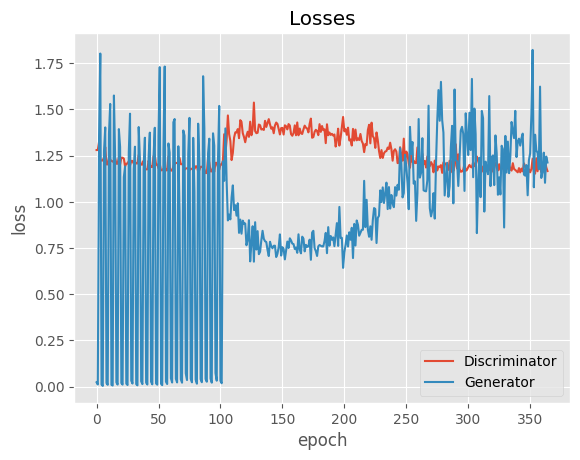

In [96]:
plt.plot(d_losses, '-')
plt.plot(g_losses, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

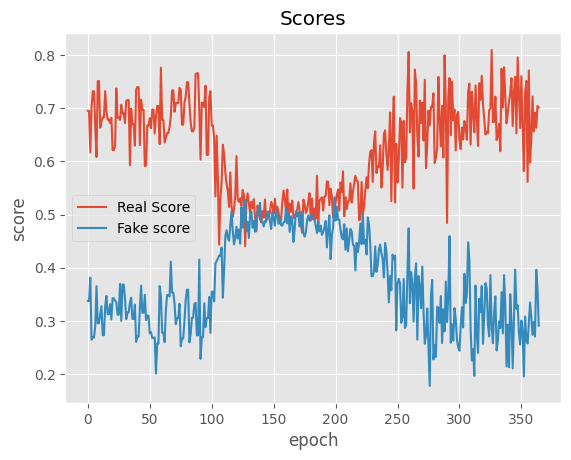

In [97]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real Score', 'Fake score'])
plt.title('Scores');

In [29]:
# import pytorch_gan_metrics
from pytorch_gan_metrics.pytorch_image_generation_metrics import (get_inception_score,
                                 get_fid,
                                 get_inception_score_and_fid)

from torch.utils.data import Dataset

# create the Generator Dataset. returns the image, generated from the Generator network
class GeneratorDataset(Dataset):
    def __init__(self, G, z_dim):
        self.G = G
        self.z_dim = z_dim

    def __len__(self):
        return 500

    def __getitem__(self, index):
        return self.G(torch.randn(1, self.z_dim, 1, 1).cuda())[0]
    

# dataset = GeneratorDataset(G, CFG.nz)
# G_dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

dataset = GeneratorDataset(G, CFG.nz)
G_dataloader = DataLoader(dataset, batch_size=32, shuffle=True)
G.to(CFG.device)

# Inception Score
IS, _ = get_inception_score(G_dataloader)
print(f"Inception Score: {IS}")

# Frechet Inception Distance
FID = get_fid(G_dataloader, 'cifar10.train.npz')
print(f"FID: {FID}")

(IS, IS_std), FID = get_inception_score_and_fid(
    G_dataloader, 'cifar10.train.npz')
print(f"Inception Score: {IS}\nFID: {FID}")

Inception Score: 2.423664902266309
FID: 205.0274707877761
Inception Score: 2.329363524866569
FID: 208.75824149318956
